# Half-circle Radial Orientation Profile Analysis
Summary: This script computes and visualizes the half-circle radial orientation profile of Striated fibers from orientation maps obtained in "AFT_SF_orientation.ipynb". It processes the angle maps of individual images to extract orientation profiles and then aggregates multiple profiles for comparative analysis.

Input:
- Orientation maps in NumPy `.npy` format, with values ranging from -90 to 90 degrees and NaN values outside the cell region.
- File path to the orientation map.
- Base folder containing multiple orientation map files for batch processing.
- Parameters for binning and profile computation.

Output:
- Individual half-circle radial orientation profiles saved as `.npy` files.
- Plots of individual profiles and combined profiles across multiple images.
- Visualizations of the half-circle region used for profile computation overlaid on the original orientation maps.
- Mean orientation profile across multiple images saved as `.npy` file.
- Plots saved in PNG and SVG formats.

C:\Users\laan\AppData\Local\Temp\ipykernel_113968\1530929134.py:51: RuntimeWarning: Mean of empty slice
  profile = np.array([np.nanmean(values[digitized == i]) for i in range(n_bins)])


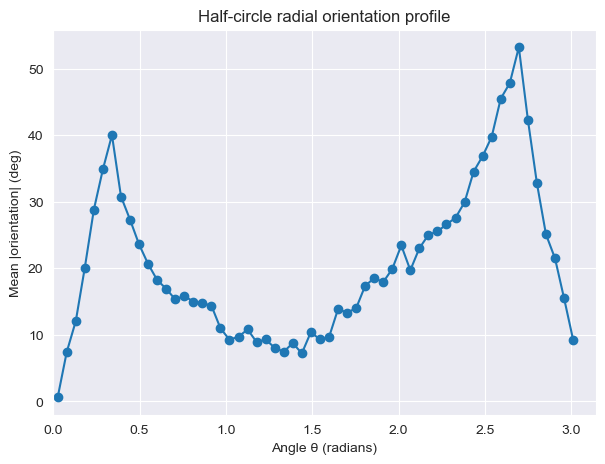

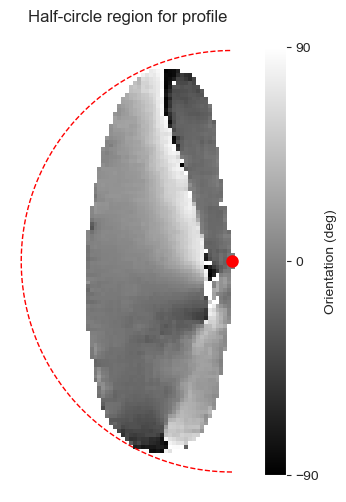

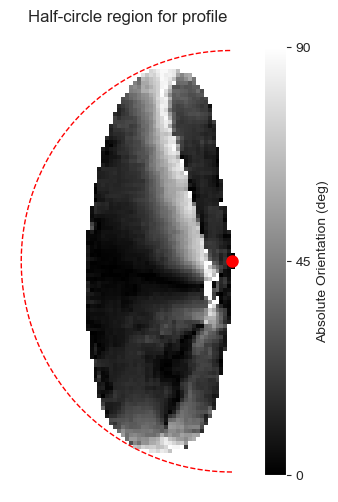

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import matplotlib as mpl
# Ensure text is saved as editable text in SVG
mpl.rcParams['svg.fonttype'] = 'none'
# Set global font to Arial
mpl.rcParams['font.family'] = 'Arial'

# ---------- Part 1: Compute and Save Profile ---------- PER IMAGE

# Load the orientation map (replace with your file path)
base_folder = "W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_SR\\Orientation Results SR\\Ventral\\"
file_path = base_folder + "MAX_ExM_ptetWT_SR_cell8_ventral_mask_skeleton_angles_in_degrees.npy"
ori_map = np.load(file_path) # values between -90 and 90, NaN outside cell

# Get coordinates of non-NaN pixels (cell mask)
ys, xs = np.nonzero(~np.isnan(ori_map))
# Compute vertical midpoint of the cell
cy = ys.mean()
# Compute right edge of the cell (max x of valid pixels at y ~ cy)
mask_vertical_band = np.abs(ys - cy) < 5
right_edge_x = xs[mask_vertical_band].max()
# Move the center 5 points to the left --> POSSIBLE TO ADJUST PER CELL
# cx = right_edge_x - 5
cx = right_edge_x

# --- Compute max radius = extent of cell from this center ---
radii = np.sqrt((xs - cx)**2 + (ys - cy)**2)
max_radius = radii.max() #-5 # --> POSSIBLE TO ADJUST PER CELL

# Compute angle from this shifted point and rotate half circle 90° left
angles = np.arctan2(ys - cy, xs - cx)
angles = np.mod(angles + np.pi/2, np.pi) # rotate 90° left, keep 0..pi

# Get absolute orientation values
values = np.abs(ori_map[ys, xs])

# Bin into angular sectors
n_bins = 60
bins = np.linspace(0, np.pi, n_bins+1)
digitized = np.digitize(angles, bins) - 1

profile = np.array([np.nanmean(values[digitized == i]) for i in range(n_bins)])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Save profile as npy file
base_name = os.path.splitext(file_path)[0]
np.save(base_name + "_profile.npy", profile)

# --- Plot profile ---
plt.figure(figsize=(7,5))
plt.plot(bin_centers, profile, '-o', lw=1.5)
plt.xlabel("Angle θ (radians)")
plt.ylabel("Mean |orientation| (deg)")
plt.title("Half-circle radial orientation profile")
plt.xlim(0, np.pi)
plt.show()

# --- Show geometry on image and save ---
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(np.flipud(ori_map), cmap="gray", origin="lower", vmin=-90, vmax=90) # flip vertically
# mark origin point
ax.plot(cx, ori_map.shape[0] - cy, 'ro', markersize=8)
# draw reference half-circle with adaptive radius
theta = np.linspace(0, np.pi, 300)
x_arc = cx + max_radius * np.cos(theta + np.pi/2)
y_arc = cy + max_radius * np.sin(theta + np.pi/2)
ax.plot(x_arc, ori_map.shape[0] - y_arc, 'r--', lw=1)
ax.set_title("Half-circle region for profile")
ax.axis("off")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[-90, 0, 90])
cbar.set_label('Orientation (deg)')
plt.savefig(base_name + "_half_circle.png", dpi=300, bbox_inches="tight")
plt.savefig(base_name + "_half_circle.svg", dpi=300, bbox_inches="tight")
plt.show()

# --- Show geometry on image and save ---
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(np.flipud(np.abs(ori_map)), cmap="gray", origin="lower", vmin=0, vmax=90) # show absolute values
# mark origin point
ax.plot(cx, ori_map.shape[0] - cy, 'ro', markersize=8)
# draw reference half-circle with adaptive radius
theta = np.linspace(0, np.pi, 300)
x_arc = cx + max_radius * np.cos(theta + np.pi/2)
y_arc = cy + max_radius * np.sin(theta + np.pi/2)
ax.plot(x_arc, ori_map.shape[0] - y_arc, 'r--', lw=1)
ax.set_title("Half-circle region for profile")
ax.axis("off")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 45, 90])
cbar.set_label('Absolute Orientation (deg)')
plt.savefig(base_name + "_half_circle_abs.png", dpi=300, bbox_inches="tight")
plt.savefig(base_name + "_half_circle_abs.svg", dpi=300, bbox_inches="tight")
plt.show()

In [2]:
# ---------- Part 2: Load Multiple Profiles and Plot Together ---------- ALL IMAGES
def plot_multiple_profiles(profile_files, n_bins=60):
    all_profiles = []

    plt.figure(figsize=(5,6))
    for pf in profile_files:
        profile = np.load(pf)
        all_profiles.append(profile)
        bin_centers = np.linspace(0, np.pi, n_bins)
        plt.plot(bin_centers, profile, color="lightgray", lw=1)

    # Compute mean profile
    all_profiles = np.array(all_profiles)
    mean_profile = np.nanmean(all_profiles, axis=0)

    plt.plot(bin_centers, mean_profile, color="black", lw=2.5, label="Mean profile")
    plt.xlabel("Angle on AP-axis (radians)", fontsize=22)
    plt.xlim(0, np.pi)
    plt.xticks([0, np.pi/2, np.pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"], size=18)
    plt.yticks(size=18)
    plt.ylabel("|angle| with AP-axis (deg)", fontsize=22)
    plt.title("Row orientation", fontsize=26, weight='bold', color='black')
    # plt.legend()
    plt.grid(False)
    plt.savefig("combined_profiles.png", dpi=300, bbox_inches="tight")
    plt.savefig("combined_profiles.svg", bbox_inches="tight")
    plt.show()

    np.save("average_profile.npy", mean_profile)

    return mean_profile

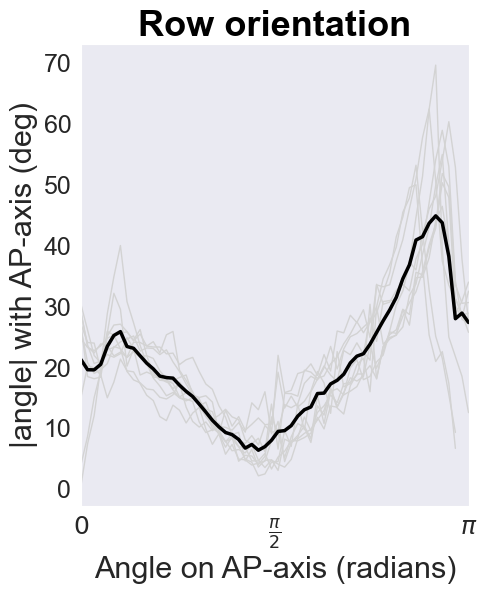

In [3]:
# Define the base folder where your _profile.npy files are saved
# base_folder = "W:/Users/Daphne/Analysis/SR filament orientation/"

# Collect all profile files in that folder
profile_files = glob.glob(os.path.join(base_folder, "*_profile.npy"))

# Plot and save the mean profile
mean_profile = plot_multiple_profiles(profile_files, n_bins=60)